In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Loading and preprocessing the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizing the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Expanding images to 3 channels to match VGG16
train_images = np.stack([train_images] * 3, axis=-1)
test_images = np.stack([test_images] * 3, axis=-1)

# Resizing the images to 48x48 to match VGG16
train_images = tf.image.resize(train_images, (48, 48))
test_images = tf.image.resize(test_images, (48, 48))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Using VGG16 without top layers
vgg16_base = VGG16(include_top=False, input_shape=(48, 48, 3), weights='imagenet')

# Unfreezing a few top layers of the VGG16 base model for fine-tuning
vgg16_base.trainable = True
for layer in vgg16_base.layers[:-4]:
    layer.trainable = False

# Adding new layers for classification
model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compiling the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Displaying the model structure
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [6]:
# Using Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=8,
    zoom_range=0.1,
    shear_range=0.3,
    width_shift_range=0.08,
    height_shift_range=0.08,
    vertical_flip=True,
    horizontal_flip=True  # Adding horizontal flipping
)
datagen.fit(train_images)

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Saving the best model
checkpoint = ModelCheckpoint('/kaggle/working/best_model.keras', monitor='val_accuracy', save_best_only=True, mode='min')

# Training the model using early stopping and saving the best model
history = model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                    epochs=50,
                    validation_data=(test_images, test_labels),
                    callbacks=[early_stopping, checkpoint])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726484550.229801     104 service.cc:145] XLA service 0x78c0540158a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726484550.229872     104 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  4/938 ━━━━━━━━━━━━━━━━━━━━ 48s 52ms/step - accuracy: 0.1152 - loss: 3.5769 

I0000 00:00:1726484557.107940     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 77ms/step - accuracy: 0.6435 - loss: 1.1356 - val_accuracy: 0.8295 - val_loss: 0.4995
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 66s 70ms/step - accuracy: 0.8262 - loss: 0.5129 - val_accuracy: 0.8639 - val_loss: 0.3877
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 67s 71ms/step - accuracy: 0.8436 - loss: 0.4499 - val_accuracy: 0.8880 - val_loss: 0.3199
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 67s 71ms/step - accuracy: 0.8614 - loss: 0.4044 - val_accuracy: 0.8883 - val_loss: 0.3141
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 67s 71ms/step - accuracy: 0.8739 - loss: 0.3637 - val_accuracy: 0.8934 - val_loss: 0.3019
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 66s 70ms/step - accuracy: 0.8793 - loss: 0.3434 - val_accuracy: 0.8969 - val_loss: 0.2933
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 72ms/step - accuracy: 0.8840 - loss: 0.3285 - val_accuracy: 0.8942 - val_loss: 0.2938
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 69s 73ms/step - accuracy: 0.8879 - loss: 0.3218 - val_accurac

In [7]:
# Loading the best saved model
model.load_weights('/kaggle/working/best_model.keras')

# Evaluating the model on the test set after fine-tuning
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy after fine-tuning: {test_acc}')

313/313 - 2s - 7ms/step - accuracy: 0.8295 - loss: 0.4995

Test accuracy after fine-tuning: 0.8295000195503235


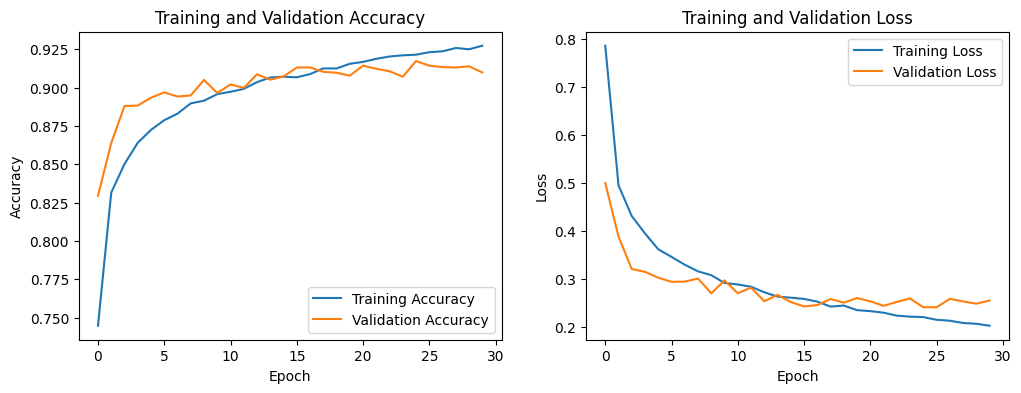

In [8]:
# Visualizing training results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


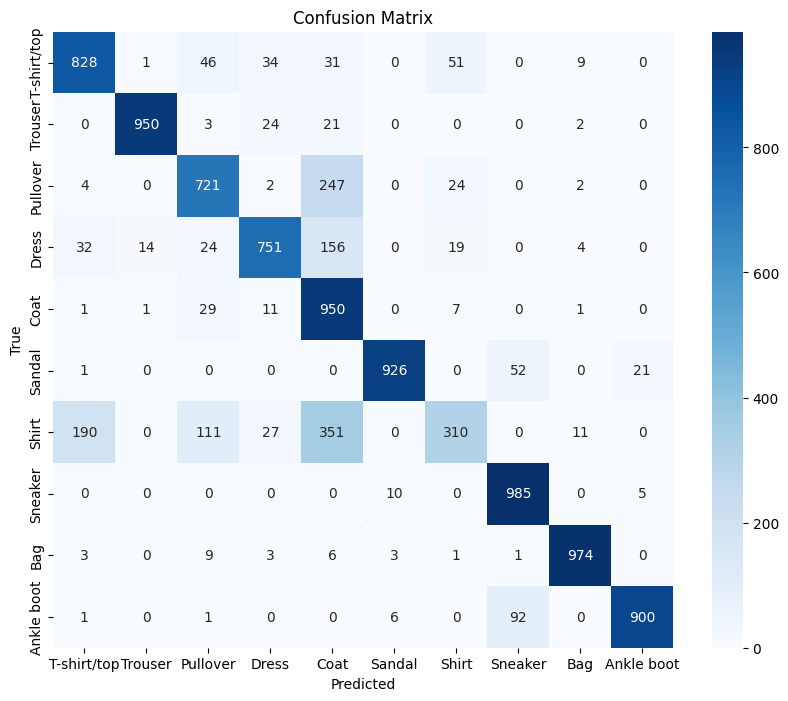

              precision    recall  f1-score   support

 T-shirt/top       0.78      0.83      0.80      1000
     Trouser       0.98      0.95      0.97      1000
    Pullover       0.76      0.72      0.74      1000
       Dress       0.88      0.75      0.81      1000
        Coat       0.54      0.95      0.69      1000
      Sandal       0.98      0.93      0.95      1000
       Shirt       0.75      0.31      0.44      1000
     Sneaker       0.87      0.98      0.92      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.90      0.93      1000

    accuracy                           0.83     10000
   macro avg       0.85      0.83      0.82     10000
weighted avg       0.85      0.83      0.82     10000



In [9]:
# Prediction
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Displaying the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(test_labels, predicted_labels, target_names=class_names))


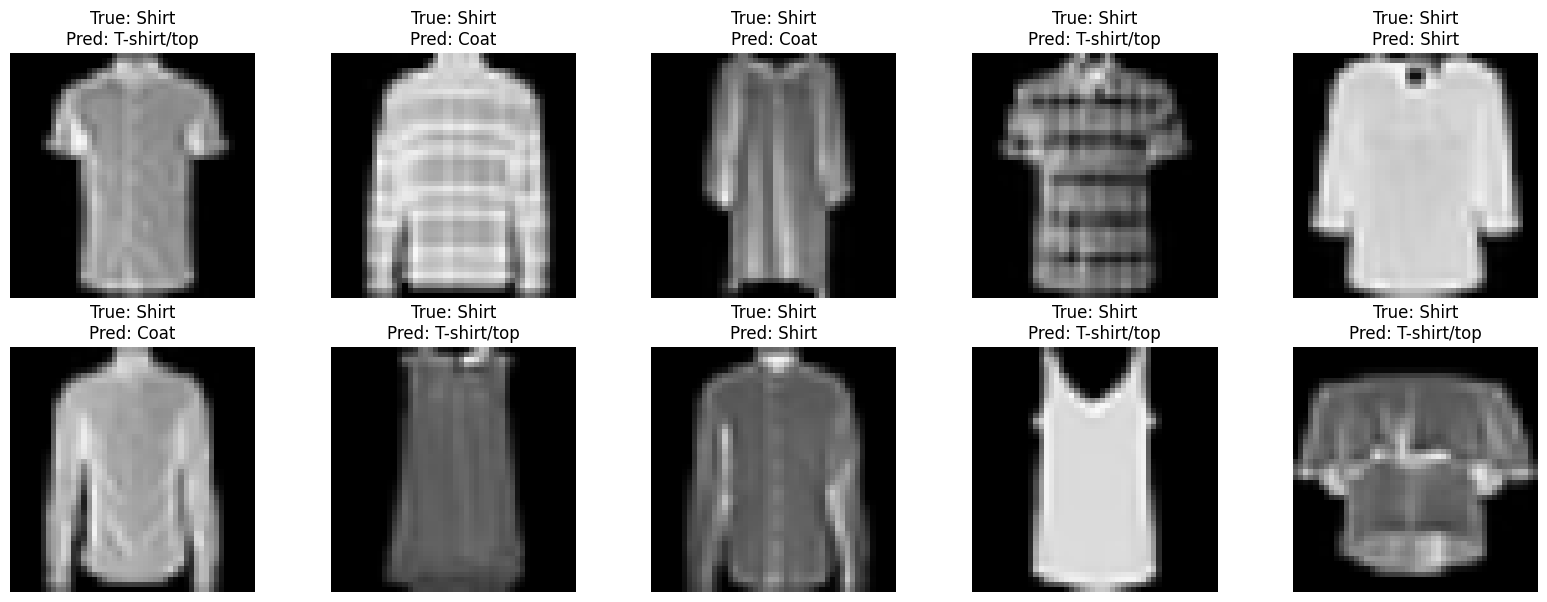

In [10]:
# Displaying 10 examples of shirts with true and predicted labels
shirt_indices = np.where(test_labels == 6)[0]  # 'Shirt' is class 6
sample_shirt_indices = np.random.choice(shirt_indices, 10, replace=False)

plt.figure(figsize=(20, 7))
for i, index in enumerate(sample_shirt_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[index].numpy().reshape(48, 48, 3))
    plt.title(f"True: {class_names[test_labels[index]]}\nPred: {class_names[predicted_labels[index]]}")
    plt.axis('off')

plt.show()